In [1]:
import sys
import os
os.chdir("..")
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import pylab as pl

from general_utils import *
from bss_utils import *
from dsp_utils import *
from polytope_utils import *
from visualization_utils import * 

import warnings
warnings.filterwarnings("ignore")

notebook_name = 'Polytope Plotting'

In [117]:
dim = 6
signed_dims = np.array([0,1, 2, 5])
nn_dims = np.array([3,4])
sparse_dims_list = [np.array([0,1, 2]), np.array([2, 4, 5])]
(A,b), V = generate_practical_polytope(dim, signed_dims, nn_dims, sparse_dims_list)

In [80]:
N = 20
NumberofSources = 6
NumberofMixtures = 10
S = generate_correlated_copula_sources(rho = 0.0, df = 4, n_sources = NumberofSources, 
                                       size_sources = N , decreasing_correlation = False)

S = 3 * S - 1.5
# print("The following is the correlation matrix of sources")
# display_matrix(np.corrcoef(S))

# Generate Mxr random mixing from i.i.d N(0,1)
A = np.random.randn(NumberofMixtures,NumberofSources)
X = np.dot(A,S)

SNR = 30
X, NoisePart = addWGN(X, SNR, return_noise = True)

SNRinp = 10 * np.log10(np.sum(np.mean((X - NoisePart)**2, axis = 1)) / np.sum(np.mean(NoisePart**2, axis = 1)))
# print("The following is the mixture matrix A")
# display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

Input SNR is : 30.041143417185236


In [142]:
np.eye(3,4)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]])

In [81]:
def resignH2(H, BoundMin):
    a = 1-2*(np.sum(H, axis=0) < 0)*(BoundMin == 0)
    AA = np.diag(np.reshape(a, (-1,)))
    H = np.dot(H, AA)
    return H

In [104]:
BoundMax = np.ones((dim,1)).T
BoundMin = -np.ones((dim,1)).T
BoundMin[:,nn_dims] = 0
BoundMax, BoundMin

(array([[1., 1., 1., 1., 1., 1.]]), array([[-1., -1., -1.,  0.,  0., -1.]]))

In [107]:
def ProjectHtoBoundaryRectangle(H):
    Hshape = H.shape
    H = resignH2(H, BoundMin)
    BoundMaxlist = np.dot(np.ones((Hshape[0],1)), BoundMax)
    BoundMinlist = np.dot(np.ones(( Hshape[0],1)), BoundMin)
    CheckMin = 1.0*(H > BoundMinlist)
    a = 1-2.0*(np.sum(CheckMin, axis=0) == 0)*(BoundMin == 0)
    AA = np.diag(np.reshape(a, (-1,)))
    H=np.dot(H,AA)
    CheckMax = 1.0*(H < BoundMaxlist)
    CheckMin = 1.0*(H > BoundMinlist)
    H = H*CheckMax*CheckMin+(1-CheckMin)*BoundMinlist+(1-CheckMax)*BoundMaxlist
    return H

In [109]:
ProjectHtoBoundaryRectangle(S.T).T

array([[-0.53193608, -0.77919619,  0.36265864,  0.92338201,  0.97213686,
         0.35382501,  0.55863571,  0.90506567, -1.        , -0.08917491,
        -0.54012869,  1.        ,  0.01655273, -1.        , -0.7739973 ,
         0.46151343, -0.71628481, -0.12188314,  0.78244179,  1.        ],
       [-0.39292478, -1.        ,  0.10100196,  0.81772676,  0.28020896,
         1.        ,  0.71890753,  0.83940877,  0.41439689, -0.975803  ,
         0.77593724, -1.        , -0.70667713,  1.        ,  1.        ,
         0.31853102, -0.9008136 ,  0.01626571,  0.1515485 , -0.05207129],
       [-0.92268075,  1.        ,  0.54625154,  0.29151833, -0.68691119,
         0.11453779,  1.        , -0.77060197, -0.61616991,  1.        ,
        -1.        , -1.        , -0.47021785,  1.        , -0.79759197,
        -0.6155912 , -0.53642473, -0.45755747,  1.        ,  1.        ],
       [ 0.99703244,  1.        ,  0.65904834,  1.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  

In [111]:
len(signed_dims)

4

In [119]:
def ProjectOntoPracticalPolytope(x, signed_dims, nn_dims, sparse_dims_list, max_number_of_iterations = 1):
    dim = len(signed_dims) + len(nn_dims)
    BoundMax = np.ones((dim,1)).T
    BoundMin = -np.ones((dim,1)).T
    BoundMin[:,nn_dims] = 0
    x_projected = x.copy()
    x_projected[signed_dims, :] = np.clip(x_projected[signed_dims, :], -1, 1)
    x_projected[nn_dims, :] = np.clip(x_projected[nn_dims, :], 0, 1)
    for kk in range(max_number_of_iterations):
        for j in range(len(sparse_dims_list)):
            x_projected = ProjectHtoBoundaryRectangle(x_projected.T).T
            x_projected[sparse_dims_list[j], :] = ProjectRowstoL1NormBall(x[sparse_dims_list[j], :].T).T
    return x_projected

In [120]:
x = np.random.randn(6,1)
print(np.linalg.norm(A @ x - b[:,np.newaxis] > 0))
x_projected = ProjectOntoPracticalPolytope(x, signed_dims, nn_dims, sparse_dims_list,
                                           max_number_of_iterations = 10 )

print(np.linalg.norm(A @ x_projected - b[:,np.newaxis] > 0))

2.23606797749979
1.0


In [121]:
print(np.sum(A @ x_projected - b[:,np.newaxis] > 0))

1


In [123]:
def ProjectOntoPracticalPolytope2(x, signed_dims, nn_dims, sparse_dims_list, max_number_of_iterations = 1):
    x_projected = x.copy()
    x_projected[signed_dims, :] = np.clip(x_projected[signed_dims, :], -1, 1)
    x_projected[nn_dims, :] = np.clip(x_projected[nn_dims, :], 0, 1)
    for kk in range(max_number_of_iterations):
        for j in range(len(sparse_dims_list)):
            x_projected[signed_dims, :] = np.clip(x_projected[signed_dims, :], -1, 1)
            x_projected[nn_dims, :] = np.clip(x_projected[nn_dims, :], 0, 1)
            x_projected[sparse_dims_list[j], :] = ProjectRowstoL1NormBall(x[sparse_dims_list[j], :].T).T
    return x_projected

In [124]:
# x = np.random.randn(6,1)
print(np.linalg.norm(A @ x - b[:,np.newaxis] > 0))
x_projected = ProjectOntoPracticalPolytope2(x, signed_dims, nn_dims, sparse_dims_list,
                                           max_number_of_iterations = 10 )

print(np.linalg.norm(A @ x_projected - b[:,np.newaxis] > 0))

2.23606797749979
1.0


In [125]:
np.sum(A @ x_projected - b[:,np.newaxis] > 0)

1

In [141]:
x = np.random.randn(6,100)
x_projected1 = ProjectOntoPracticalPolytope(x, signed_dims, nn_dims, sparse_dims_list,
                                           max_number_of_iterations = 10 )
x_projected2 = ProjectOntoPracticalPolytope2(x, signed_dims, nn_dims, sparse_dims_list,
                                           max_number_of_iterations = 10 )
np.linalg.norm(x_projected1 - x_projected2)

0.0

In [118]:
A.shape, b.shape

((28, 6), (28,))

In [89]:
S - resignH2(S.T, np.array([[-1,-1,-1,0,0,1]])).T

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-1.99406488, -2.59944623, -1.31809668, -2.20895609,  2.60421046,
        -2.66129693,  2.42811856,  2.62483182, -

In [74]:
def ProjectOntoPracticalPolytope(x, signed_dims, nn_dims, sparse_dims_list, max_number_of_iterations = 1):
    x_projected = x.copy()
    x_projected[signed_dims, :] = np.clip(x_projected[signed_dims, :], -1, 1)
    x_projected[nn_dims, :] = np.clip(x_projected[nn_dims, :], 0, 1)
    for kk in range(max_number_of_iterations):
        for j in range(len(sparse_dims_list)):
            x_projected[signed_dims, :] = np.clip(x_projected[signed_dims, :], -1, 1)
            x_projected[nn_dims, :] = np.clip(x_projected[nn_dims, :], 0, 1)
            x_projected[sparse_dims_list[j], :] = ProjectRowstoL1NormBall(x[sparse_dims_list[j], :].T).T
    return x_projected

In [4]:
dim = 6
signed_dims = np.array([0,1, 2, 5])
nn_dims = np.array([3,4])
sparse_dims_list = [np.array([0,1, 2]), np.array([2, 4, 5])]
(A,b), V = generate_practical_polytope(dim, signed_dims, nn_dims, sparse_dims_list)

In [5]:
np.linalg.norm(A @ V - b[:,np.newaxis] > 0 )

0.0

In [ ]:
hull = ConvexHull(V.T)
x = np.random.randn(6,)

In [39]:
np.sum(equations[:,:-1]**2, axis = 1).shape

(496,)

In [40]:
(-(equations[:,-1] + np.dot(equations[:,:-1], pt))).shape

(496,)

In [49]:
t_list = []
for eq in hull.equations:
    t = -(eq[-1] + np.dot(eq[:-1], pt))/(np.sum(eq[:-1]**2))
    t_list.append(t)
    pt_proj = pt + eq[:-1]*t

In [54]:
distances[100:150]

array([0.57062876, 0.57062876, 0.57062876, 0.57062876, 0.57062876,
       0.57062876, 0.57062876, 0.57062876, 0.57062876, 0.57062876,
       0.57062876, 0.57062876, 0.57062876, 0.57062876, 0.57062876,
       0.57062876, 0.57062876, 0.57062876, 0.57062876, 0.57062876,
       0.57062876, 0.57062876, 0.57062876, 0.57062876, 0.57062876,
       0.57062876, 0.57062876, 0.57062876, 0.57062876, 0.57062876,
       0.57062876, 0.57062876, 0.57062876, 0.57062876, 0.57062876,
       0.57062876, 0.57062876, 0.57062876, 0.57062876, 0.57062876,
       0.57062876, 0.57062876, 0.57062876, 0.57062876, 0.57062876,
       0.57062876, 0.57062876, 0.57062876, 0.57062876, 0.57062876])

In [55]:
np.array(t_list)[100:150]

array([0.57062876, 0.57062876, 0.57062876, 0.57062876, 0.57062876,
       0.57062876, 0.57062876, 0.57062876, 0.57062876, 0.57062876,
       0.57062876, 0.57062876, 0.57062876, 0.57062876, 0.57062876,
       0.57062876, 0.57062876, 0.57062876, 0.57062876, 0.57062876,
       0.57062876, 0.57062876, 0.57062876, 0.57062876, 0.57062876,
       0.57062876, 0.57062876, 0.57062876, 0.57062876, 0.57062876,
       0.57062876, 0.57062876, 0.57062876, 0.57062876, 0.57062876,
       0.57062876, 0.57062876, 0.57062876, 0.57062876, 0.57062876,
       0.57062876, 0.57062876, 0.57062876, 0.57062876, 0.57062876,
       0.57062876, 0.57062876, 0.57062876, 0.57062876, 0.57062876])

In [47]:
np.linalg.norm(A @ pt_proj.reshape(-1,1) - b[:,np.newaxis] > 0 )

2.8284271247461903

In [48]:
# hull = ConvexHull(V.T)
# x = np.random.randn(6,)
pt = x.copy()
equations = hull.equations
distances = (-(equations[:,-1] + np.dot(equations[:,:-1], pt))/(np.sum(equations[:,:-1]**2, axis = 1)))
min_distance = np.max(distances)
argmin_distances = np.where(distances == min_distance)[0][0]
# argmin_distances = 332
# argmin_distances = np.argmin(distances)
print(argmin_distances)
pt_proj = pt + equations[argmin_distances, :-1]*distances[argmin_distances]
np.linalg.norm(A @ pt_proj.reshape(-1,1) - b[:,np.newaxis] > 0 )

160


1.7320508075688772

In [24]:
min_distance = np.min(distances)
np.where(distances == min_distance)

(array([318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330,
        331, 332]),)

In [45]:
x_projected = ProjectOntoPracticalPolytope(x.reshape(-1,1), signed_dims, nn_dims, sparse_dims_list, 
                                           max_number_of_iterations = 10, )
np.linalg.norm(A @ x_projected.reshape(-1,1) - b[:,np.newaxis] > 0 )

1.4142135623730951

In [9]:
pt_proj

array([-0.37814472, -0.94537251,  0.32351723, -0.18913818,  0.17588667,
       -0.89184083])

In [10]:
x_projected

array([[-0.2163861 ],
       [-0.7836139 ],
       [-0.07210073],
       [ 0.        ],
       [ 0.10597256],
       [-0.82192671]])

In [54]:
x = np.random.randn(6,)
pt = x
for eq in hull.equations:
    t = -(eq[-1] + np.dot(eq[:-1], pt))/(np.sum(eq[:-1]**2))
    pt_proj = pt + eq[:-1]*t
    break

In [86]:
eq = hull.equations[100]
-(eq[-1] + np.dot(eq[:-1], pt))/(np.sum(eq[:-1]**2))

1.3761765763093468

In [82]:
np.sum(equations[:,:-1]**2, axis = 1).shape

(496,)

In [88]:
equations = hull.equations
distances = (-(equations[:,-1] + np.dot(equations[:,:-1], pt))/(np.sum(equations[:,:-1]**2, axis = 1)))
argmin_distances = np.argmin(distances)
pt_proj = pt + equations[argmin_distances, :-1]*distances[argmin_distances]

In [90]:
np.linalg.norm(A @ pt_proj.reshape(-1,1) - b[:,np.newaxis] > 0 )

2.449489742783178

In [91]:
A @ pt_proj.reshape(-1,1) - b[:,np.newaxis]

array([[-1.38426604e+00],
       [-6.15733955e-01],
       [-2.42877441e+00],
       [ 4.28774411e-01],
       [-1.41992222e+00],
       [-5.80077781e-01],
       [-1.60890597e+00],
       [-3.91094027e-01],
       [-1.45634574e+00],
       [ 4.56345738e-01],
       [-1.88983754e-01],
       [-8.11016246e-01],
       [-3.23296267e+00],
       [-2.39311824e+00],
       [-3.75413852e-01],
       [ 4.64430585e-01],
       [-2.46443059e+00],
       [-1.62458615e+00],
       [ 3.93118237e-01],
       [ 1.23296267e+00],
       [-1.21781195e+00],
       [-4.44089210e-16],
       [-2.83984444e+00],
       [-1.62203249e+00],
       [-3.77967508e-01],
       [ 8.39844437e-01],
       [-2.00000000e+00],
       [-7.82188055e-01]])

In [ ]:
vertices = pypoman.compute_polytope_vertices(A, b)

In [17]:
A, b = pypoman.compute_polytope_halfspaces(V.T)

In [19]:
A

array([[-0., -0., -0., -0., -1., -0.],
       [-0., -0., -0., -1., -0., -0.],
       [-1., -1., -1., -0., -0., -0.],
       [-1., -1.,  1., -0., -0., -0.],
       [-1.,  1., -1., -0., -0., -0.],
       [-1.,  1.,  1., -0., -0., -0.],
       [-0., -0., -1., -0.,  1., -1.],
       [-0., -0.,  1., -0.,  1., -1.],
       [-0., -0.,  1., -0.,  1.,  1.],
       [-0., -0., -1., -0.,  1.,  1.],
       [-0., -0., -0.,  1., -0., -0.],
       [ 1., -1., -1., -0., -0., -0.],
       [ 1., -1.,  1., -0., -0., -0.],
       [ 1.,  1., -1., -0., -0., -0.],
       [ 1.,  1.,  1., -0., -0., -0.]])

In [20]:
def ProjectOntoPracticalPolytope(x, signed_dims, nn_dims, sparse_dims_list, inequalities = (None, None), max_number_of_iterations = 1, tolerance = 1e-7):
    x_projected = x.copy()
    if (inequalities[0] is not None) & (inequalities[1] is not None):
        A = inequalities[0]
        b = inequalities[1].reshape(-1,1)
    else:
        tolerance = -100
        
    x_projected[signed_dims] = np.clip(x_projected[signed_dims], -1, 1)
    x_projected[nn_dims] = np.clip(x_projected[nn_dims], 0, 1)
    
    for kk in range(max_number_of_iterations):
        for j in range(len(sparse_dims_list)):
            x_projected[signed_dims] = np.clip(x_projected[signed_dims], -1, 1)
            x_projected[nn_dims] = np.clip(x_projected[nn_dims], 0, 1)
            x_projected[sparse_dims_list[j]] = ProjectRowstoL1NormBall(x[sparse_dims_list[j]].T).T
#             x_projected[signed_dims] = np.clip(x_projected[signed_dims], -1, 1)
#             x_projected[nn_dims] = np.clip(x_projected[nn_dims], 0, 1)
        print(np.linalg.norm(np.clip(A @ x_projected - b[:,np.newaxis],0, 1e10)))
        if np.linalg.norm(np.clip(A @ x_projected - b[:,np.newaxis],0, 1e10)) < tolerance:
            break
    return x_projected

In [31]:
def ProjectOntoPracticalPolytope(x, signed_dims, nn_dims, sparse_dims_list, max_number_of_iterations = 1):
    x_projected = x.copy()
    x_projected[signed_dims, :] = np.clip(x_projected[signed_dims, :], -1, 1)
    x_projected[nn_dims, :] = np.clip(x_projected[nn_dims, :], 0, 1)
    for kk in range(max_number_of_iterations):
        for j in range(len(sparse_dims_list)):
            x_projected[signed_dims, :] = np.clip(x_projected[signed_dims, :], -1, 1)
            x_projected[nn_dims, :] = np.clip(x_projected[nn_dims, :], 0, 1)
            x_projected[sparse_dims_list[j], :] = ProjectRowstoL1NormBall(x[sparse_dims_list[j], :].T).T
    return x_projected

In [32]:
dim = 6
signed_dims = np.array([0,1, 2, 5])
nn_dims = np.array([3,4])
sparse_dims_list = [np.array([0,1, 2]), np.array([2, 4, 5])]
(A,b), V = generate_practical_polytope(dim, signed_dims, nn_dims, sparse_dims_list)
A, b = pypoman.compute_polytope_halfspaces(V.T)

In [33]:
A.shape, b.shape, V.shape

((15, 6), (15,), (6, 28))

In [34]:
np.linalg.norm(A @ V - b[:,np.newaxis] > 0 )

0.0

In [148]:
%timeit x_projected = ProjectOntoPracticalPolytope(x, signed_dims, nn_dims, sparse_dims_list,max_number_of_iterations = 10, )

8.63 ms ± 206 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
print(np.linalg.norm(A @ x - b[:,np.newaxis] > 0))

2.0


In [36]:
x = np.random.randn(6,1)
print(np.linalg.norm(A @ x - b[:,np.newaxis] > 0))
x_projected = ProjectOntoPracticalPolytope(x, signed_dims, nn_dims, sparse_dims_list,
#                                            inequalities = (A, b), 
                                           max_number_of_iterations = 10, )
#                                            tolerance = 1e-7)
print(np.linalg.norm(A @ x_projected - b[:,np.newaxis] > 0))

1.4142135623730951
1.0


-0.22261360551227877
0.019060446338142523
1.0168288961785295
0.5129164424126303
0.8710549434061678
0.5741658203671057


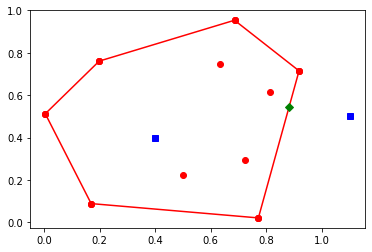

In [158]:
from scipy.spatial import Delaunay, ConvexHull
import numpy as np
np.random.seed(10)
hu = np.random.rand(10, 2) ## the set of points to get the hull from
pt = np.array([1.1, 0.5]) ## a point outside
pt2 = np.array([0.4, 0.4]) ## a point inside
hull = ConvexHull(hu) ## get only the convex hull
#hull2 = Delaunay(hu) ## or get the full Delaunay triangulation

import matplotlib.pyplot as plt
plt.plot(hu[:,0], hu[:,1], "ro") ## plot all points
#plt.triplot(hu[:,0], hu[:,1], hull2.simplices.copy()) ## plot the Delaunay triangulation
## Plot the convexhull
for simplex in hull.simplices:
    plt.plot(hu[simplex,0], hu[simplex,1], "ro-")

## Plot the points inside and outside the convex hull 
plt.plot(pt[0], pt[1], "bs")
plt.plot(pt2[0], pt2[1], "bs")

for eq in hull.equations:
    t = -(eq[-1] + np.dot(eq[:-1], pt))/(np.sum(eq[:-1]**2))
    print(t)
    if t == -0.22261360551227877:
        pt_proj = pt + eq[:-1]*t
        plt.plot(pt_proj[0], pt_proj[1], "gD-.")
plt.show()

In [152]:
hull.equations

array([[-0.9774029 ,  0.21138491,  0.14799135],
       [ 0.22303558,  0.97481031, -1.05222084],
       [-0.52881237, -0.84873876,  0.3037754 ],
       [ 0.98846467, -0.15145165, -0.80225976],
       [ 0.77226509, -0.63530042, -0.43994271]])

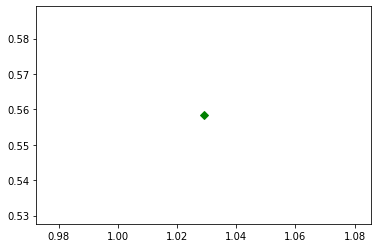

In [153]:
plt.plot(pt_proj[0], pt_proj[1], "gD-.")

In [143]:
x_projected

array([[-0.64175666],
       [-0.08065974],
       [ 0.        ],
       [ 0.59088941],
       [ 0.93861423],
       [-0.06138577]])

In [147]:
print(np.linalg.norm(A @ x - b[:,np.newaxis] > 0))
x_projected = ProjectOntoPracticalPolytope(X, signed_dims, nn_dims, sparse_dims_list,
#                                            inequalities = (A, b), 
                                           max_number_of_iterations = 10, )
#                                            tolerance = 1e-7)
print(np.linalg.norm(A @ x_projected - b[:,np.newaxis] > 0))
x_projected

2.449489742783178
0.0


array([[-0.64175666,  0.63431838],
       [-0.08065974,  0.36568162],
       [ 0.        ,  0.        ],
       [ 0.59088941,  0.        ],
       [ 0.93861423,  0.46308057],
       [-0.06138577, -0.53691943]])

In [126]:
np.linalg.norm(np.clip(A @ x_projected - b[:,np.newaxis],0, 1e10))

1.5562303162879976

In [125]:
(A @ x_projected - b[:,np.newaxis]).T

array([[-7.34977954e-01, -1.26502205e+00, -1.00000000e+00,
        -1.00000000e+00, -1.40765956e+00, -5.92340441e-01,
        -4.07659559e-01, -1.59234044e+00, -1.00000000e+00,
         0.00000000e+00, -1.00000000e+00,  0.00000000e+00,
        -1.14263751e+00, -3.27318395e-01, -1.14263751e+00,
        -3.27318395e-01, -1.67268161e+00, -8.57362486e-01,
        -1.67268161e+00, -8.57362486e-01, -8.15319119e-01,
        -2.00000000e+00, -8.15319119e-01, -2.00000000e+00,
         0.00000000e+00, -1.18468088e+00,  0.00000000e+00,
        -1.18468088e+00],
       [-1.32963765e+00, -6.70362351e-01, -4.13635493e-01,
        -1.58636451e+00, -7.12161431e-01, -1.28783857e+00,
        -1.32529878e+00, -6.74701217e-01, -1.00000000e+00,
         0.00000000e+00, -9.07485558e-01, -9.25144417e-02,
        -4.55434573e-01, -1.03111171e+00, -1.62816359e+00,
        -2.20384073e+00,  2.03840726e-01, -3.71836413e-01,
        -9.68888289e-01, -1.54456543e+00, -9.44945773e-01,
        -2.94348206e-01, -1.12

In [112]:
print(np.linalg.norm(A @ x - b[:,np.newaxis] > 0))
x_projected = ProjectOntoPracticalPolytope(x, signed_dims, nn_dims, sparse_dims_list,
                                           inequalities = (A, b), max_number_of_iterations = 50, 
                                           tolerance = 1e-7)
print(np.linalg.norm(A @ x_projected - b[:,np.newaxis] > 0))

2.8284271247461903
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
2.714180691430312
0.0


In [76]:
np.linalg.norm(np.clip(A @ x_projected - b[:,np.newaxis],0, 1e10))

0.20202522215378815

In [78]:
(A @ x_projected - b[:,np.newaxis]).T

array([[-0.18601154, -1.81398846, -1.17642312, -0.82357688, -1.        ,
        -1.        , -1.79797478, -0.20202522, -1.        ,  0.        ,
        -1.20202522,  0.20202522, -0.36243465, -0.36243465, -0.00958842,
        -0.00958842, -1.99041158, -1.99041158, -1.63756535, -1.63756535,
        -2.        , -0.40405044, -1.59594956,  0.        , -2.        ,
        -0.40405044, -1.59594956,  0.        ]])

In [79]:
dim = 3
signed_dims = np.array([0,1])
nn_dims = np.array([2])
sparse_dims_list = [np.array([0,1]),np.array([1,2])]
(A,b), V = generate_practical_polytope(dim, signed_dims, nn_dims, sparse_dims_list)

In [103]:
x = np.random.randn(3,1)
print(np.linalg.norm(A @ x - b[:,np.newaxis] > 0))
x_projected = ProjectOntoPracticalPolytope(x, signed_dims, nn_dims, sparse_dims_list,
                                           inequalities = (A, b), max_number_of_iterations = 10, 
                                           tolerance = 1e-7)
print(np.linalg.norm(A @ x_projected - b[:,np.newaxis] > 0))

1.0
1.0


In [104]:
(A @ x_projected - b[:,np.newaxis]).T

array([[-0.48348274, -1.51651726, -0.80807358, -1.19192642, -1.06756623,
         0.06756623, -0.29155632, -0.67540916, -1.32459084, -1.70844368,
        -0.87563981, -0.74050735, -1.25949265, -1.12436019]])

In [59]:
x_projected

array([[ 0.83093197],
       [-0.16906803],
       [-0.38164226],
       [ 0.64950642],
       [ 0.        ],
       [-0.61835774]])

In [61]:
(A @ x_projected - b[:,np.newaxis])

array([[-0.16906803],
       [-1.83093197],
       [-1.16906803],
       [-0.83093197],
       [-1.38164226],
       [-0.61835774],
       [-1.61835774],
       [-0.38164226],
       [-0.35049358],
       [-0.64950642],
       [-1.        ],
       [ 0.        ],
       [-0.71977832],
       [ 0.0435062 ],
       [-0.38164226],
       [ 0.38164226],
       [-2.38164226],
       [-1.61835774],
       [-2.0435062 ],
       [-1.28022168],
       [-2.        ],
       [-0.76328452],
       [-2.        ],
       [-0.76328452],
       [-1.23671548],
       [ 0.        ],
       [-1.23671548],
       [ 0.        ]])

In [63]:
np.linalg.norm(np.clip(A @ x_projected - b[:,np.newaxis],0, 1e10))

0.38411404908653657

In [18]:
x_projected = ProjectOntoPracticalPolytope(x, signed_dims, nn_dims, sparse_dims_list, inequalities = (A, b), max_number_of_iterations = 5, tolerance = 1e-7)

In [19]:
np.linalg.norm(A @ x_projected - b[:,np.newaxis] > 0)

0.0

In [136]:
x = np.random.randn(6,1)*10
k = 5
x = V[:,k][:,np.newaxis] * 5
print(V[:,k])
np.linalg.norm(A @ x - b[:,np.newaxis] > 0)

[0. 1. 0. 1. 1. 0.]


3.3166247903554

In [139]:
def ProjectOntoPracticalPolytope(x, signed_dims, nn_dims, sparse_dims, inequalities = (None, None), max_number_of_iterations = 1, tolerance = 1e-7):
    x_projected = x.copy()
    if (inequalities[0] is not None) & (inequalities[1] is not None):
        A = inequalities[0]
        b = inequalities[1].reshape(-1,1)
    else:
        tolerance = -100
        
    for kk in range(max_number_of_iterations):
        for j in range(len(sparse_dims_list)):
            x_projected[sparse_dims_list[j]] = ProjectRowstoL1NormBall(x[sparse_dims_list[j]].T).T
            x_projected[signed_dims] = np.clip(x_projected[signed_dims], -1, 1)
            x_projected[nn_dims] = np.clip(x_projected[nn_dims], 0, 1)
        if np.linalg.norm(A @ x_projected - b > 0) < tolerance:
            break
    return x_projected

In [137]:
x_projected = x.copy()
print(x_projected.T)
for kk in range(1):
#     x_projected[signed_dims] = np.clip(x_projected[signed_dims], -1, 1)
#     print(x_projected.T)
#     x_projected[nn_dims] = np.clip(x_projected[nn_dims], 0, 1)
#     print(x_projected.T)
    for j in range(len(sparse_dims_list)):
        x_projected[sparse_dims_list[j]] = ProjectRowstoL1NormBall(x[sparse_dims_list[j]].T).T
        x_projected[signed_dims] = np.clip(x_projected[signed_dims], -1, 1)
        x_projected[nn_dims] = np.clip(x_projected[nn_dims], 0, 1)
        print(x_projected.T)

[[0. 5. 0. 5. 5. 0.]]
[[-0.  1. -0.  1.  1.  0.]]
[[-0.  1. -0.  1.  1. -0.]]


array([[0.],
       [0.],
       [5.],
       [5.],
       [0.],
       [0.]])

In [124]:
np.linalg.norm(A @ x_projected - b[:,np.newaxis] > 0)

0.0

In [125]:
A @ x_projected - b[:,np.newaxis]

array([[-2.],
       [ 0.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 0.],
       [-2.],
       [ 0.],
       [-1.],
       [-1.],
       [ 0.],
       [-2.],
       [-2.],
       [-2.],
       [-2.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-2.],
       [ 0.],
       [-2.],
       [ 0.],
       [-2.],
       [ 0.],
       [-2.]])

In [100]:
import cvxpy
import cvxpy as cvx

In [101]:
def polyproject(point, polyhedron=None, vertices=None):
    """
    Projects a point onto a convex polyhedron. Makes use of cvxpy.
    The polyhedron can be specified either as a set of vertices, or as a matrix
    of equations describing the polyhedron. In the former case, the convex hull
    of the vertices is computed. In the latter case, the input is a matrix `A`
    such that A * [x, y, z]^T = [0, 0, 0]^T (in 3D).
    Parameters
    ----------
    point : array of shape (ndim,)
        Point to project onto the polyhedron
    polyhedron : array of shape (nfacets, ndim+1), optional
        Array containing the matrix of equations describing the polyhedron.
        Either this option or `vertices` must be provided.
    vertices : array of shape (nvertices, ndim), optional
        Array containing the vertices of the polyhedron. Either this parameter
        or `polyhedron` must be provided. Ignored if polyhedron is provided.
    Returns
    -------
    proj_point : array of shape (ndim,)
        Projection of the given point onto the convex polyhedron.
    polyhedron : array of shape (nfacets, ndim+1), optional
        Array containing the matrix of equations describing the polyhedron.
    Raises
    ------
    ValueError
        If neither `vertices` nor `polyhedron` is provided.
    """

    if polyhedron is None:
        if vertices is None:
            raise ValueError('Must provide either vertices or polyhedron.')
        from scipy.spatial import ConvexHull
        conv_hull = ConvexHull(vertices)
        polyhedron = conv_hull.equations

    # Set up the convex optimization problem
    ndim = point.size
    x = cvx.Variable(ndim)
    objective = cvx.Minimize(cvx.sum(cvx.square(x - point)))
    constraints = [polyhedron[:, :-1] * x <= -polyhedron[:, -1],]
    prob = cvx.Problem(objective, constraints)

    final_obj = prob.solve()
    #print(final_obj)
    #print(x.value)

    # Convert x.value from matrix type to ndarray type.
    # NOTE: This will have to change after cvxpy 1.0, which is more numpythonic
    return np.squeeze(np.asarray(x.value)), polyhedron

In [102]:
x_projected, _ = polyproject(x.reshape(-1,), polyhedron=None, vertices=V.T)

In [106]:
np.linalg.norm(A @ x_projected - b[:,np.newaxis] > 0)

5.291502622129181

In [115]:
x_projected = x.copy()
print(x_projected.T)
for kk in range(1):
#     x_projected[signed_dims] = np.clip(x_projected[signed_dims], -1, 1)
#     print(x_projected.T)
#     x_projected[nn_dims] = np.clip(x_projected[nn_dims], 0, 1)
#     print(x_projected.T)
    for j in range(len(sparse_dims_list)):
        x_projected[sparse_dims_list[j]] = ProjectRowstoL1NormBall(x[sparse_dims_list[j]].T).T
        x_projected[signed_dims] = np.clip(x_projected[signed_dims], -1, 1)
        x_projected[nn_dims] = np.clip(x_projected[nn_dims], 0, 1)
        print(x_projected.T)

[[-0.49616637 -2.27095709  0.26868361  0.90740432 -0.90467566  1.26638916]]
[[ 0.         -1.         -0.          0.90740432  0.          1.        ]]
[[ 0.         -1.         -0.          0.90740432  0.          0.68085675]]


In [116]:
np.linalg.norm(A @ x_projected - b[:,np.newaxis] > 0)

0.0

In [78]:
A @ x_projected - b[:,np.newaxis]

array([[-5.10845232e-01],
       [-1.48915477e+00],
       [-1.51084523e+00],
       [-4.89154768e-01],
       [-1.62970441e+00],
       [-3.70295586e-01],
       [-7.33508898e-01],
       [-1.26649110e+00],
       [ 0.00000000e+00],
       [-1.00000000e+00],
       [-1.10380448e+00],
       [ 1.03804484e-01],
       [-1.65139488e+00],
       [-3.91986051e-01],
       [-6.29704414e-01],
       [ 6.29704414e-01],
       [-2.62970441e+00],
       [-1.37029559e+00],
       [-1.60801395e+00],
       [-3.48605122e-01],
       [-1.46701780e+00],
       [-2.00000000e+00],
       [-1.25940883e+00],
       [-1.79239103e+00],
       [-2.07608968e-01],
       [-7.40591172e-01],
       [-2.22044605e-16],
       [-5.32982204e-01]])

In [44]:
x = np.random.randn(6,1)
A @ x - b[:,np.newaxis]

array([[-2.85356028],
       [ 0.85356028],
       [-1.07786576],
       [-0.92213424],
       [-1.07113465],
       [-0.92886535],
       [ 0.61124489],
       [-2.61124489],
       [-0.89226189],
       [-0.10773811],
       [ 0.61381818],
       [-1.61381818],
       [-3.0025607 ],
       [-2.8602914 ],
       [-2.84682917],
       [-2.70455987],
       [ 0.70455987],
       [ 0.84682917],
       [ 0.8602914 ],
       [ 1.0025607 ],
       [ 2.15392842],
       [-1.06856136],
       [-1.07370794],
       [-4.29619772],
       [ 2.29619772],
       [-0.92629206],
       [-0.93143864],
       [-4.15392842]])

In [28]:
A @ x - b[:,np.newaxis]

array([[ 0.40066134],
       [-2.40066134],
       [ 1.59191559],
       [-3.59191559],
       [-0.36308441],
       [-1.63691559],
       [ 3.62949252],
       [ 2.35566134],
       [-1.55433865],
       [-2.82816984],
       [ 0.82816984],
       [-0.44566135],
       [-4.35566134],
       [-5.62949252]])

In [29]:
np.linalg.norm(A @ x - b[:,np.newaxis] > 0 )

2.23606797749979

In [36]:
x_projected = ProjectRowstoL1NormBall(x.T).T

In [38]:
np.linalg.norm(A @ x_projected - b[:,np.newaxis] > 0 )

0.0